In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Value:
  def __init__(self, data, children=(), op='', label = ''):
    self.data = data
    self.gradient = 0.0
    self.backward = lambda: None
    self.prev = set(children)
    self.op = op
    self.label = label

  def __add__(self, other_val):
    other_val = other_val if isinstance(other_val, Value) else Value(other_val)
    out = Value (self.data + other_val.data, (self, other_val), op = '+')
    def backward():
      self.gradient += out.gradient
      other_val.gradient += out.gradient

    out.backward = backward
    return out

  def __radd__(self,other_val):
    return self * other_val

  def __neg__(self):
    return self * -1

  def __sub__(self, other_val):
    other_val = other_val if isinstance(other_val, Value) else Value(other_val)
    return self + (-other_val)


  def __mul__(self, other_val):
    other_val = other_val if isinstance(other_val, Value) else Value(other_val)
    out = Value(self.data * other_val.data, (self,other_val), op = '*')

    def backward():
      self.gradient += other_val.data * out.gradient
      other_val.gradient += self.data * out.gradient

    out.backward = backward
    return out

  def __rmul__(self, other_val):
    return self * other_val

  def __truediv__(self, other_val):
    return self * other_val ** -1


  def tanh(self):
    n = self.data
    tanh = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
    out = Value(tanh, (self,), 'tanh')

    def backward():
      self.gradient += (1 - tanh**2) *out.gradient

    out.backward = backward
    return out

  def __pow__(self, other_val):
    assert isinstance(other_val, (int, float)) # Support only int and float in pow
    out = Value(self.data ** other_val, (self,), f"**{other_val}")

    def backward():
      self.gradient += other_val * self.data ** (other_val - 1) * out.gradient
    out.backward = backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')

    def backward():
      self.grad += out.data * out.grad

    out.backward = backward
    return out

  def __repr__(self):
    return f"Value(data={self.data})"

  def backprop(self):
    topologic = []
    visited = set()
    def build_topological(v):
      if v not in visited:
        visited.add(v)
        for child in v.prev:
          build_topological(child)
        topologic.append(v)
    build_topological(self)

    self.gradient = 1.0
    for node in reversed(topologic):
      node.backward()



In [ ]:
from graphviz import Digraph


def trace(root):
  nodes, edges = set() , set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw(root):
  dot = Digraph(format = 'svg', graph_attr = {'rankdir':'LR'}) # LEFT -> RIGHT

  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))

    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.gradient), shape = "record")

    if n.op:
      dot.node(uid + n.op, n.op)

      dot.edge(uid + n.op, uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)
  return dot

In [ ]:
#inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias
b = Value(6.88137, label = 'b1')

x1w1 = x1 * w1
x1w1.label = 'x1w1'

x2w2 = x2 * w2
x2w2.label = 'x2w2'

x1w1_plus_x2w2 = x1w1 + x2w2
x1w1_plus_x2w2.label = 'x1w1 + x2w2'

n = x1w1_plus_x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backprop()

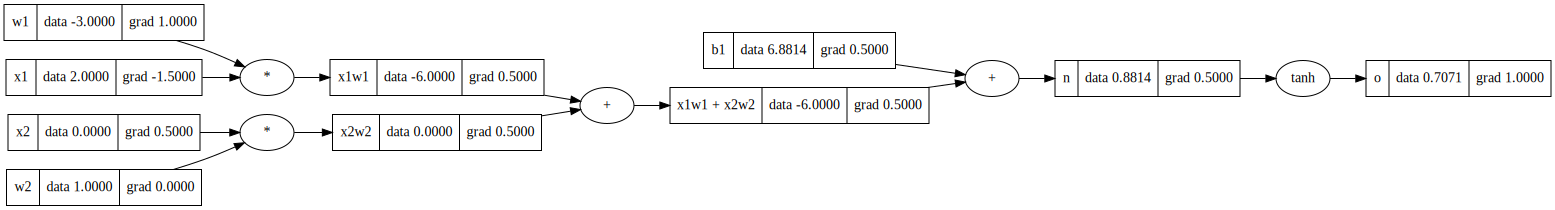

In [ ]:
draw(o)

In [ ]:
class Neuron:
  def __init__(self, n_in):
    self.w = [Value(np.random.uniform(-1,1)) for item in range(n_in)]
    self.b = Value(np.random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = activation.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, n_in, n_out):
    self.neurons = [Neuron(n_in) for _ in range(n_out)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]



In [ ]:
class MLP:
  def __init__(self, n_in, n_out):
    size = [n_in] + n_out
    self.layers = [Layer(size[i], size[i+1]) for i in range(len(n_out))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])


In [ ]:
n(x)

Value(data=0.31096893674280274)

In [ ]:
features = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
] # features

targets = [1.0, -1.0, -1.0, 1.0] # targets

In [ ]:
for k in range(10):
  #forward pass
  ypred = [n(x) for x in features]
  loss = sum(((yout - ytrue)**2) for yout, ytrue in zip(ypred, targets))

  # backward pass
  for p in n.parameters():
    p.gradient = 0.0

  loss.backprop()

  #update
  for p in n.parameters():
    p.data -= 0.05 * p.gradient


  print(f"iter, mse:{k, loss.data}")



iter, mse:(0, 4.436517587957576)
iter, mse:(1, 2.4309785481023805)
iter, mse:(2, 1.9480669501317824)
iter, mse:(3, 1.4758152708260766)
iter, mse:(4, 1.0523704873570927)
iter, mse:(5, 0.7293579735458298)
iter, mse:(6, 0.5150410786132228)
iter, mse:(7, 0.3797881857725137)
iter, mse:(8, 0.29290783479243165)
iter, mse:(9, 0.2346660757970353)


0.01533893512039114

0.0

0.3683598438975205